In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pytz
from skyfield import api, data
import satpred
import skychart

In [2]:
plt.rcParams['figure.figsize'] = [15, 15]

In [3]:
load = api.Loader('./data')

In [4]:
ts = load.timescale()
ephemeris = load('de421.bsp')
satellites = load.tle('http://celestrak.com/NORAD/elements/stations.txt', reload=True)
with load.open(data.hipparcos.URL) as f:
    df = data.hipparcos.load_dataframe(f)

[#################################] 100% stations.txt


In [5]:
sun = ephemeris['sun']
earth = ephemeris['earth']
iss = satellites['ISS']
manhattan_beach_ca_usa = api.Topos(latitude='33.881519 N', longitude='118.388177 W', elevation_m=33)
pacific = pytz.timezone('US/Pacific')
bright_stars = df[df['magnitude'] <= 5.]
more_stars = df[df['magnitude'] <= 7.]

In [6]:
tle_line_1 = "1 25544U 98067A   19174.96066161 -.00001641  00000-0 -19667-4 0  9994"
tle_line_2 = "2 25544  51.6426 327.6827 0008340  79.1947  72.7878 15.51216338176304"
iss = api.EarthSatellite(tle_line_1, tle_line_2, name='ISS (ZARYA)', ts=ts)

In [7]:
d0 = datetime.datetime(2019, 6, 1, 0, 0)
t0 = ts.utc(pacific.localize(d0))
d1 = datetime.datetime(2019, 6, 11, 0, 0)
t1 = ts.utc(pacific.localize(d1))

In [8]:
df = satpred.SatelliteEphemeris(t0, t1, iss, manhattan_beach_ca_usa, earth, sun).to_dataframe()

In [9]:
columns = ['date', 'peak_magnitude', 'start', 'start_alt', 'start_az', 'start_d', 'culm', 'culm_alt', 
         'culm_az', 'culm_d', 'end', 'end_alt', 'end_az', 'end_d']

In [10]:
len(df)

10

In [11]:
df[columns]

,date,peak_magnitude,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d
0,2019-06-01,-0.3,21:18:14,10,NNE,1498,21:18:40,10,NNE,1486,21:19:07,10,NNE,1498
1,2019-06-01,0.2,22:52:31,10,NW,1498,22:53:57,23,NW,935,22:53:57,23,NW,933
2,2019-06-02,-2.1,22:03:09,10,NNW,1497,22:06:11,34,NE,698,22:06:11,35,NE,698
3,2019-06-03,-1.7,21:13:58,10,NNW,1496,21:16:35,21,NE,1006,21:18:28,14,ENE,1283
4,2019-06-03,0.0,22:50:13,10,WNW,1496,22:51:17,17,WNW,1118,22:51:17,18,WNW,1116
5,2019-06-04,-3.3,22:00:29,10,NW,1495,22:03:38,69,WSW,446,22:03:38,69,WSW,446
6,2019-06-05,-3.4,21:10:59,10,NW,1494,21:14:17,54,NE,506,21:16:02,24,ESE,903
7,2019-06-06,-1.5,21:58:35,10,WNW,1493,22:01:11,21,SW,991,22:01:20,21,SW,993
8,2019-06-07,-2.8,21:08:35,10,WNW,1493,21:11:46,42,SW,605,21:13:52,18,SSE,1083
9,2019-06-09,-0.9,21:07:23,10,W,1490,21:09:04,13,SW,1302,21:10:46,10,SSW,1488


In [12]:
satephem = satpred.SatelliteEphemeris(t0, t1, iss, manhattan_beach_ca_usa, earth, sun, visible=False)
df = satephem.to_dataframe()

In [13]:
columns = ['date', 'start', 'start_alt', 'start_az', 'start_d', 'culm', 'culm_alt', 
         'culm_az', 'culm_d', 'end', 'end_alt', 'end_az', 'end_d', 'pass_type']

In [14]:
df[columns]

,date,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d,pass_type
0,2019-06-01,14:44:56,10,S,1467,14:47:48,27,SE,810,14:50:41,10,ENE,1479,daylight
1,2019-06-01,16:21:42,10,W,1475,16:24:26,23,NW,920,16:27:11,10,NNE,1485,daylight
2,2019-06-01,21:18:14,10,NNE,1498,21:18:40,10,NNE,1486,21:19:07,10,NNE,1498,visible
3,2019-06-01,22:52:31,10,NW,1498,22:55:52,68,NE,450,22:59:13,10,SE,1494,visible
4,2019-06-02,13:56:34,10,SSE,1466,13:58:24,14,SE,1241,14:00:15,10,E,1474,daylight
5,2019-06-02,15:31:38,10,WSW,1471,15:34:46,40,NW,613,15:37:57,10,NNE,1483,daylight
6,2019-06-02,22:03:09,10,NNW,1497,22:06:16,35,NE,697,22:09:23,10,ESE,1495,visible
7,2019-06-02,23:40:24,10,W,1496,23:42:43,17,SW,1124,23:45:01,10,S,1492,eclipsed
8,2019-06-03,14:41:54,10,SW,1468,14:45:12,83,NW,414,14:48:31,10,NE,1481,daylight
9,2019-06-03,16:21:16,10,NW,1481,16:22:19,11,NNW,1415,16:23:22,10,N,1484,daylight


In [15]:
df[df['pass_type'] == 'visible'][columns]

,date,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d,pass_type
2,2019-06-01,21:18:14,10,NNE,1498,21:18:40,10,NNE,1486,21:19:07,10,NNE,1498,visible
3,2019-06-01,22:52:31,10,NW,1498,22:55:52,68,NE,450,22:59:13,10,SE,1494,visible
6,2019-06-02,22:03:09,10,NNW,1497,22:06:16,35,NE,697,22:09:23,10,ESE,1495,visible
10,2019-06-03,21:13:58,10,NNW,1496,21:16:35,21,NNE,1006,21:19:12,10,E,1495,visible
11,2019-06-03,22:50:13,10,WNW,1496,22:53:18,34,SW,711,22:56:22,10,SSE,1492,visible
15,2019-06-04,22:00:29,10,NW,1495,22:03:49,72,SW,438,22:07:10,10,SE,1492,visible
18,2019-06-05,21:10:59,10,NW,1494,21:14:17,54,NE,506,21:17:35,10,ESE,1492,visible
23,2019-06-06,21:58:35,10,WNW,1493,22:01:11,21,SW,991,22:03:48,10,S,1490,visible
27,2019-06-07,21:08:35,10,WNW,1493,21:11:46,42,SW,605,21:14:57,10,SSE,1490,visible
35,2019-06-09,21:07:23,10,W,1490,21:09:04,13,SW,1302,21:10:46,10,SSW,1488,visible


In [16]:
above_alt_40 = df['culm_alt'] > 40. 
visible = df['pass_type'] == 'visible'
df[visible & above_alt_40][columns]

,date,start,start_alt,start_az,start_d,culm,culm_alt,culm_az,culm_d,end,end_alt,end_az,end_d,pass_type
3,2019-06-01,22:52:31,10,NW,1498,22:55:52,68,NE,450,22:59:13,10,SE,1494,visible
15,2019-06-04,22:00:29,10,NW,1495,22:03:49,72,SW,438,22:07:10,10,SE,1492,visible
18,2019-06-05,21:10:59,10,NW,1494,21:14:17,54,NE,506,21:17:35,10,ESE,1492,visible
27,2019-06-07,21:08:35,10,WNW,1493,21:11:46,42,SW,605,21:14:57,10,SSE,1490,visible


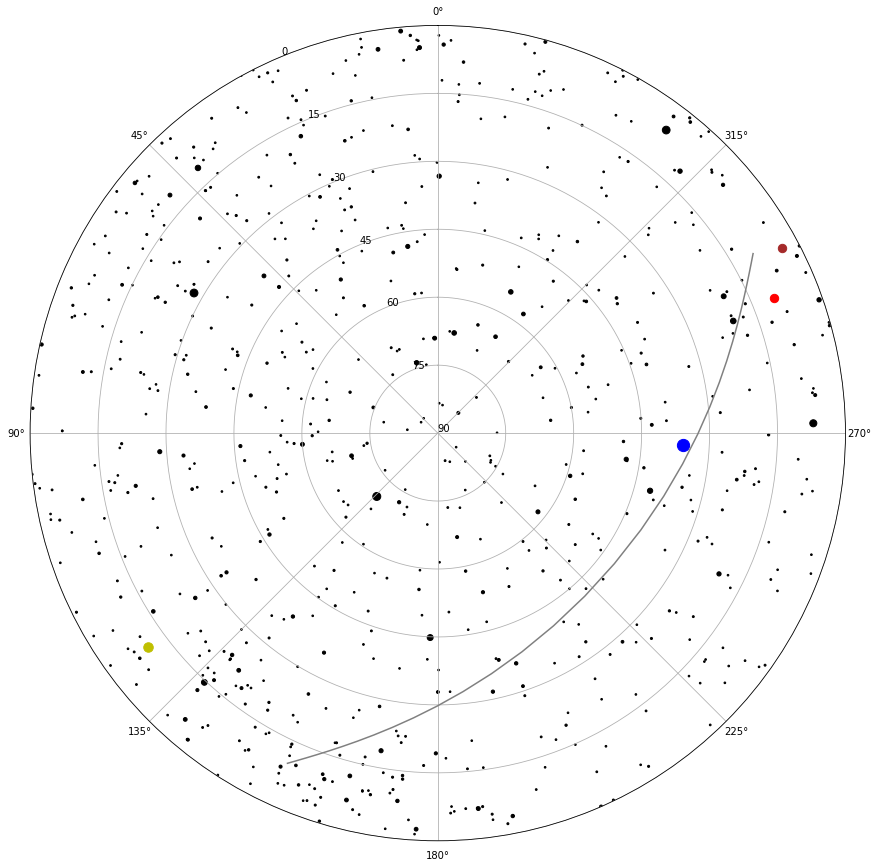

In [19]:
satellite_pass = satephem.passes[27]
chart = skychart.AltAzFullSkyChart(satellite_pass.topos + earth, satellite_pass.start_time)
chart.plot_stars(bright_stars)
chart.plot_ephemeris_object(ephemeris['sun'], 150, 'y')
chart.plot_ephemeris_object(ephemeris['moon'], 150, 'b')
chart.plot_ephemeris_object(ephemeris['mercury'], 70, 'brown')
chart.plot_ephemeris_object(ephemeris['venus'], 90, 'g')
chart.plot_ephemeris_object(ephemeris['mars'], 70, 'r')
chart.plot_ephemeris_object(ephemeris['JUPITER BARYCENTER'], 90, 'y')
chart.plot_ephemeris_object(ephemeris['SATURN BARYCENTER'], 80, 'y')
chart.plot_satellite_pass(satellite_pass)
chart.display()

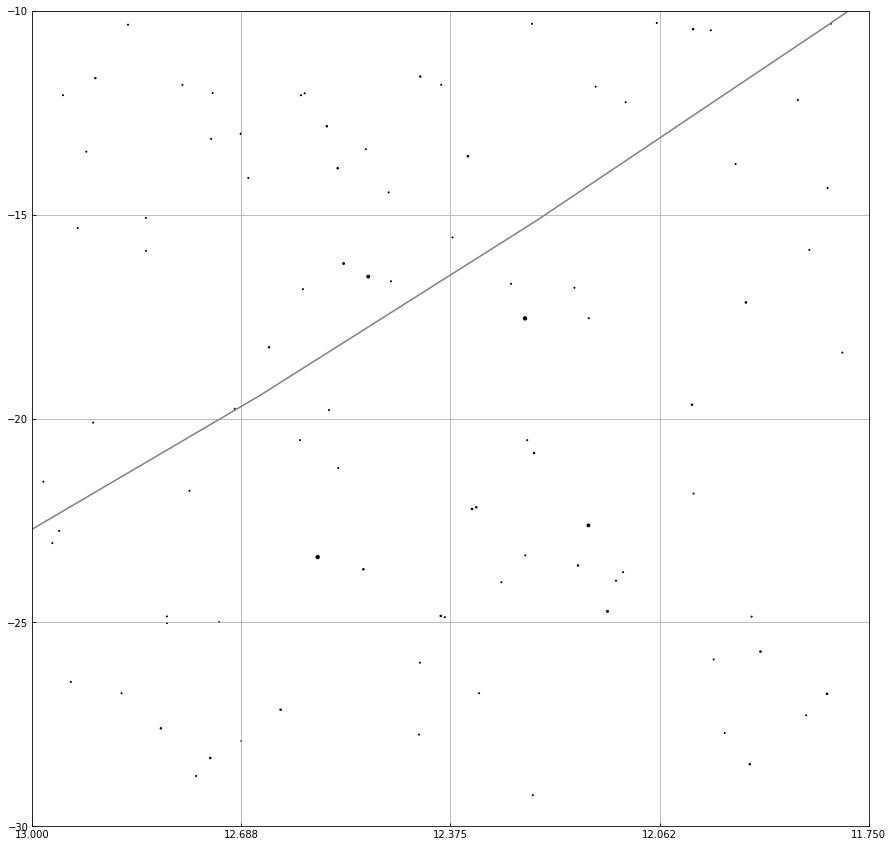

In [20]:
chart = skychart.RADecSkyChart(satellite_pass.topos + earth, satellite_pass.start_time, (13.0, 11.75), (-30, -10))
chart.plot_stars(more_stars)
chart.plot_satellite_pass(satellite_pass)
chart.display()